# Project 1 solutions: filling histograms

## Problem statement

**Goal:** Using either the `compute_mass` device function we introduced earlier or a sample of precomputed masses, fill a 120-bin histogram from 0 to 120 $\mbox{GeV}/c^2$.

In this first method, create an array with dimensions `(10000000, 120)` and have each thread fill its own row of the two-dimensional array. The columns are histogram bins. Afterward, sum over the rows, leaving only the columns.

When your computed `bin_values` are inserted into a histogram, like this:

```python
h = Hist.new.Reg(120, 0, 120, label="mass").Double()
h.values()[:] = bin_values

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");
```

The plot should look like this:

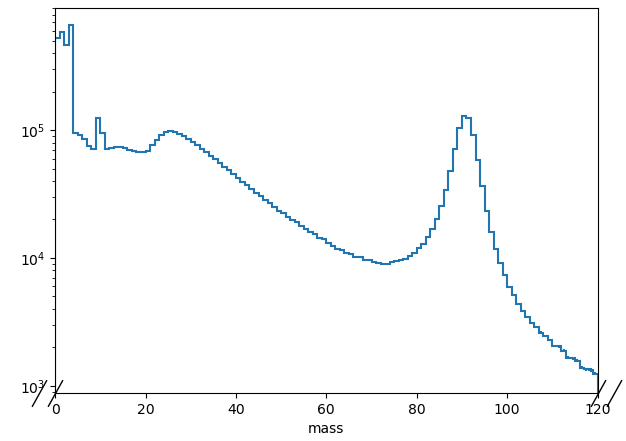

**Stretch goal:** The method above uses a lot of memory; it wouldn't work if you have many histograms to fill in the same kernel.

In this second method, create a 1200-bin histogram (also from 0 to 120 $\mbox{GeV}/c^2$) as a one-dimensional array with length `1200`. All of the threads will be filling this one row of histogram bins, so they will have to be filled atomically. Declare the array dtype to be `np.int32` and use the `nb.cuda.atomic.add` function ([documentation](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html)).

When your computed `bin_values` are inserted into a histogram, like this:

```python
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");
```

The plot should look like this:

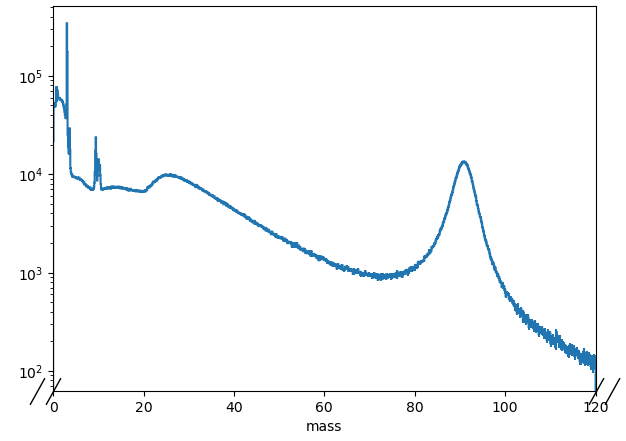

because you have 10× as many bins.

How do the speeds of the two methods compare (using precomputed masses, not counting transfer to or from the GPU)?

How does the speed scale as you reduce the number of bins?

<br><br><br><br><br>

## Loading data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba.cuda
import numba as nb
import uproot
import awkward as ak
from hist import Hist
ak.numba.register_and_check()

To load the raw data (30‒40 seconds) and `compute_mass` so that you can fill the histogram on the fly, use this:

In [ ]:
with uproot.open("root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root:Events") as tree:
    events_pt, events_eta, events_phi, events_charge = tree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"], entry_stop=10000000, how=tuple)

events = ak.to_backend(ak.zip({
    "pt": events_pt,
    "eta": events_eta,
    "phi": events_phi,
    "charge": events_charge,
}), "cuda")

@numba.cuda.jit(extensions=[ak.numba.cuda], device=True)
def compute_mass(event):
    for i, mu1 in enumerate(event):
        for mu2 in event[i + 1:]:
            if mu1.charge != mu2.charge:
                return sqrtf(2*mu1.pt*mu2.pt*(coshf(mu1.eta - mu2.eta) - cosf(mu1.phi - mu2.phi)))
    return -1

To load the precomputed masses, use this:

In [46]:
with uproot.open("../data/dimuon_mass.root:tree/mass") as branch:
    mass = cp.asarray(branch.array(library="np"))

<br><br><br><br><br>

## Filling a histogram by reduction

In [54]:
histogram_bins = cp.zeros((10000000, 120), np.int32)

In [56]:
nb.cuda.atomic.add

numba.cuda.stubs.atomic.add

In [50]:
bin_values = h.values()

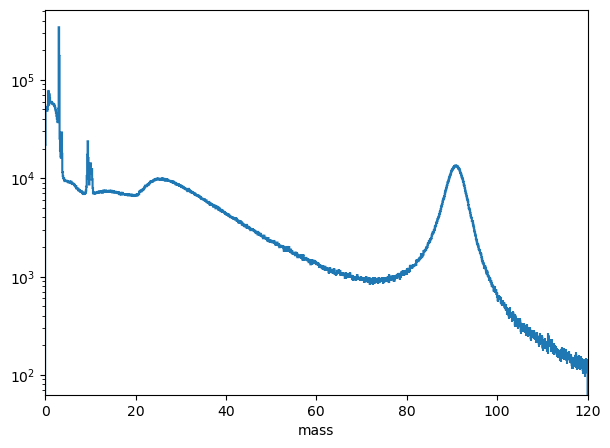

In [52]:
fig, ax = plt.subplots(figsize=(7, 5))

h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values

h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

In [2]:
events_ttree = uproot.open("root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root:Events")

In [7]:
events_pt, events_eta, events_phi, events_charge = events_ttree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"], entry_stop=10000000, how=tuple)

37.4402117729187

In [8]:
events = ak.to_backend(ak.zip({
    "pt": events_pt,
    "eta": events_eta,
    "phi": events_phi,
    "charge": events_charge,
}), "cuda")

In [9]:
from numba.cuda.libdevice import sqrtf, coshf, cosf

@numba.cuda.jit(extensions=[ak.numba.cuda], device=True)
def compute_mass(event):
    for i, mu1 in enumerate(event):
        for mu2 in event[i + 1:]:
            if mu1.charge != mu2.charge:
                return sqrtf(2*mu1.pt*mu2.pt*(coshf(mu1.eta - mu2.eta) - cosf(mu1.phi - mu2.phi)))
    return -1

@numba.cuda.jit(extensions=[ak.numba.cuda])
def fill_mass(events, mass):
    thread_idx = nb.cuda.grid(1)
    mass[thread_idx] = compute_mass(events[thread_idx])

mass = cp.empty(len(events), dtype=np.float32)

num_threads = 1024
num_blocks = int(np.ceil(len(events) / 1024))

fill_mass[num_blocks, num_threads](events, mass)

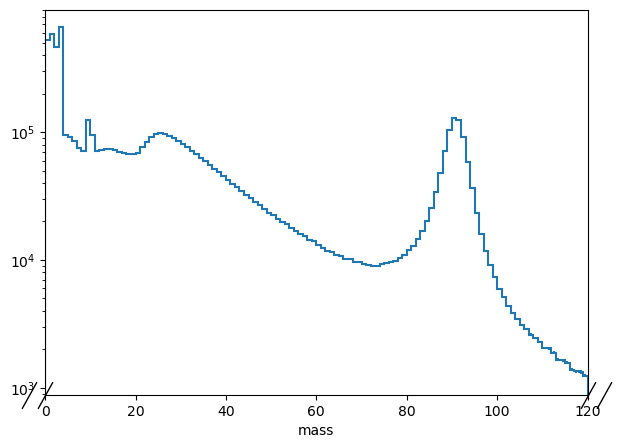

In [55]:
fig, ax = plt.subplots(figsize=(7, 5))

Hist.new.Reg(120, 0, 120, label="mass").Double().fill(mass.get()).plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

In [19]:
len(mass) / 100

100000.0

In [13]:
mass.get()

array([96.08437   , -1.        , 18.25135   , ..., 21.76483   ,
        0.6888827 ,  0.11970807], dtype=float32)

In [18]:
mass.nbytes / 100 / 1024**2

0.3814697265625

In [20]:
with uproot.recreate("/tmp/dimuon_mass.root") as file:
    tree = file.mktree("tree", {"mass": np.float32}, title="Sample of dimuon masses for the histogramming exercise.")
    start = stop = 0
    for _ in range(100):
        stop += 100000
        tree.extend({"mass": mass[start:stop].get()})
        start = stop

In [23]:
again = uproot.open("/tmp/dimuon_mass.root:tree/mass").array(library="np")

In [24]:
again

array([96.08437   , -1.        , 18.25135   , ..., 21.76483   ,
        0.6888827 ,  0.11970807], dtype=float32)

In [26]:
np.all(again == mass.get())

True